In [1]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(20)
cfg.set_tbl_cols(50)
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/conda/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dep

In [2]:
PERCENTILES = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]

In [3]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/building_blocks.json', 'r') as f:
    bbs_meta = json.load(f)

[print(k, '-->', len(v)) for k, v in bbs_meta.items()]

train_bbs --> 1145
train_bb1s --> 271
train_bb2s --> 693
train_bb3s --> 872
test_bb1s --> 341
test_bb2s --> 1140
test_bb3s --> 1389
test_bbs --> 2110
all_bbs --> 2110


[None, None, None, None, None, None, None, None, None]

In [4]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/scaffolds.json', 'r') as f:
    scaffolds = json.load(f)
print(len(scaffolds))

5971685


In [5]:
train_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_scaffold.csv').collect()
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv')\
    .select(
        pl.col('molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('BRD4', 'HSA', 'eSH').cast(pl.UInt8),
        scaffold_idx = train_scaffolds['scaffold_idx'],
    )\
    .collect()
print(train_df.estimated_size('mb'))
train_df

8601.91998577118


molecule,bb1,bb2,bb3,BRD4,HSA,eSH,scaffold_idx
str,u16,u16,u16,u8,u8,u8,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172


In [6]:
test_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_scaffold.csv').collect()
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v2.csv')\
    .select(
        pl.col('id','molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('protein'),
        scaffold_idx = test_scaffolds['scaffold_idx']
    ).group_by('molecule').first().collect()
print(test_df.estimated_size('mb'))
test_df

84.21934127807617


molecule,id,bb1,bb2,bb3,protein,scaffold_idx
str,i64,u16,u16,u16,str,i64
"""Cc1ccnc2ccc(-c…",295484575,149,836,2040,"""BRD4""",1860147
"""COc1cc(OC)cc(-…",295312030,1270,297,446,"""BRD4""",1652571
"""COC(=O)c1ccc2n…",296318714,1022,654,1657,"""BRD4""",359321
"""O=C(N[Dy])c1nc…",296516138,504,724,152,"""BRD4""",3653278
"""CCCc1ccc(-c2cc…",295421548,1249,1144,978,"""BRD4""",3336239
"""N#Cc1ccc(Nc2nc…",296352350,359,1279,65,"""BRD4""",3500670
"""CC1(C)CC(C(=O)…",295536283,592,705,1312,"""sEH""",4905609
"""O=C(N[Dy])[C@@…",296712181,198,1082,78,"""BRD4""",3226661
"""O=C1CC(C(=O)N2…",296888143,542,607,1672,"""BRD4""",2726008


In [7]:
878_022 * 3

2634066

In [8]:
2634066 / 98_415_610

0.026764717507720574

In [9]:
df = pl.concat([train_df.select(pl.col('molecule', 'bb1', 'bb2', 'bb3', 'scaffold_idx'), ori=pl.lit(0)),
                test_df.select(pl.col('molecule', 'bb1', 'bb2', 'bb3', 'scaffold_idx'), ori= pl.lit(1))])
df = df.with_columns(
    pl.col('molecule').count().over('scaffold_idx').alias('mol_per_scaf')
)

df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844


In [10]:
df['ori'].sum()

878022

In [11]:
df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844


In [12]:
train_df = df.filter(pl.col('ori') == 0)
train_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844


In [13]:
train_df.filter(pl.col('mol_per_scaf').is_between(6000, 6116))['mol_per_scaf'].unique()

mol_per_scaf
u32
6005
6009
6016
6039
6052
6113
6116


In [14]:
test_df = df.filter(pl.col('ori') == 1)
test_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""Cc1ccnc2ccc(-c…",149,836,2040,1860147,1,1
"""COc1cc(OC)cc(-…",1270,297,446,1652571,1,6
"""COC(=O)c1ccc2n…",1022,654,1657,359321,1,167
"""O=C(N[Dy])c1nc…",504,724,152,3653278,1,2
"""CCCc1ccc(-c2cc…",1249,1144,978,3336239,1,1
"""N#Cc1ccc(Nc2nc…",359,1279,65,3500670,1,3612
"""CC1(C)CC(C(=O)…",592,705,1312,4905609,1,2
"""O=C(N[Dy])[C@@…",198,1082,78,3226661,1,1
"""O=C1CC(C(=O)N2…",542,607,1672,2726008,1,1


In [15]:
369039 * 3

1107117

In [16]:
all_bbs = bbs_meta['all_bbs']
test_only_bbs = set(bbs_meta['test_bbs']).difference(bbs_meta['train_bbs'])
print('Number of test only building blocks:', len(test_only_bbs))
test_only_bb_idxs = [all_bbs.index(bb) for bb in test_only_bbs]
test2_df = df.filter(~((pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs))) & pl.col('ori') == 1)
test2_df

Number of test only building blocks: 965


molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""COC(=O)c1ccc2n…",1022,654,1657,359321,1,167
"""O=C(N[Dy])c1nc…",504,724,152,3653278,1,2
"""Cc1ccccc1-c1cs…",1577,1011,955,323982,1,993
"""Cc1nn(C)c2ncc(…",977,730,1841,1232031,1,288
"""COC(=O)c1ccc2n…",141,24,1657,957473,1,188
"""COc1ncc(Nc2nc(…",1123,830,1220,220317,1,1329
"""C#CC[C@@H](CC(…",1640,1242,2026,1281519,1,6116
"""Cc1cc(F)ccc1Nc…",1575,1199,712,2651247,1,776
"""COc1cc(C(=O)N[…",1422,1556,596,483951,1,659


In [17]:
test1_df = df.filter(((pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs))) & pl.col('ori') == 1)
test1_df.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
508983,70,447,518,245841,1,1014


In [18]:
len(list(set(test1_df['bb1'].to_list() + test1_df['bb2'].to_list() + test1_df['bb3'].to_list())))

965

In [19]:
508_983 * 3

1526949

In [20]:
test2_df.select(pl.n_unique('*'))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
369039,271,693,871,123824,1,2331


In [21]:
len(list(set(test2_df['bb1'].to_list() + test2_df['bb2'].to_list() + test2_df['bb3'].to_list())))

1145

In [22]:
train_scaffolds = list(set(train_df['scaffold_idx'].to_list()))
len(train_scaffolds)

5711873

In [23]:
test2_scaffolds = list(set(test2_df['scaffold_idx'].to_list()))
len(test2_scaffolds)

123824

In [24]:
test2_only_scaffold_idxs = set(test2_scaffolds).difference(set(train_scaffolds))
len(test2_only_scaffold_idxs)

15908

In [25]:
test3_df = test2_df.filter(pl.col('scaffold_idx').is_in(test2_only_scaffold_idxs))
test3_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""COC(=O)c1ccc2n…",1022,654,1657,359321,1,167
"""O=C(N[Dy])c1nc…",504,724,152,3653278,1,2
"""C#CC[C@@H](CC(…",1640,1242,2026,1281519,1,6116
"""COc1cc(C(=O)N[…",1422,1556,596,483951,1,659
"""CC1CN(S(=O)(=O…",171,2003,1937,4816126,1,1
"""CC(C)(C)c1nnc(…",550,2066,1131,4243260,1,8
"""O=C(COC[C@H]1C…",766,730,615,1841029,1,256
"""COc1ncc(Nc2nc(…",1946,830,423,5382949,1,4
"""Cn1ccc2cc(Nc3n…",186,1795,1085,1988879,1,87


In [26]:
test4_df = test2_df.filter(~pl.col('scaffold_idx').is_in(test2_only_scaffold_idxs))
test4_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""Cc1ccccc1-c1cs…",1577,1011,955,323982,1,993
"""Cc1nn(C)c2ncc(…",977,730,1841,1232031,1,288
"""COC(=O)c1ccc2n…",141,24,1657,957473,1,188
"""COc1ncc(Nc2nc(…",1123,830,1220,220317,1,1329
"""Cc1cc(F)ccc1Nc…",1575,1199,712,2651247,1,776
"""Cc1ccc(CNc2nc(…",1993,1146,975,1062125,1,11
"""Cc1nncn1CCCNc1…",971,249,1367,4010337,1,47
"""C=CCOC(C)CNc1n…",1457,196,1963,2287328,1,860
"""COC(=O)c1cscc1…",1483,1194,1227,3589772,1,27876


In [100]:
test2_df['mol_per_scaf'].describe(percentiles = PERCENTILES)

statistic,value
str,f64
"""count""",369039.0
"""null_count""",0.0
"""mean""",8847.973656
"""std""",44135.506861
"""min""",1.0
"""1%""",1.0
"""2.5%""",1.0
"""5%""",2.0
"""10%""",8.0


In [108]:
test2_df.filter(pl.col('mol_per_scaf') <= 2)

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""O=C(N[Dy])c1nc…",504,724,152,3653278,1,2
"""CC1CN(S(=O)(=O…",171,2003,1937,4816126,1,1
"""O=C(N[Dy])[C@@…",1147,547,1636,1152678,1,1
"""Cc1cccc2oc(CCN…",1775,433,2085,4729637,1,1
"""COc1cc(CNc2nc(…",1759,857,1705,1990006,1,2
"""O=C(CC[C@H](Nc…",1423,1405,2081,5425841,1,1
"""O=C(N[Dy])[C@@…",1239,1372,1405,5860529,1,1
"""CCC1=NN(Cc2ccc…",722,344,925,5551587,1,2
"""O=C(N[Dy])C(CC…",582,260,731,3872980,1,2


In [121]:
test3_df.filter(pl.col('mol_per_scaf') >= 2)

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""COC(=O)c1ccc2n…",1022,654,1657,359321,1,167
"""O=C(N[Dy])c1nc…",504,724,152,3653278,1,2
"""C#CC[C@@H](CC(…",1640,1242,2026,1281519,1,6116
"""COc1cc(C(=O)N[…",1422,1556,596,483951,1,659
"""CC(C)(C)c1nnc(…",550,2066,1131,4243260,1,8
"""O=C(COC[C@H]1C…",766,730,615,1841029,1,256
"""COc1ncc(Nc2nc(…",1946,830,423,5382949,1,4
"""Cn1ccc2cc(Nc3n…",186,1795,1085,1988879,1,87
"""CN(C)c1cccnc1C…",1946,28,81,3398675,1,8


In [109]:
19_078 / 369039.0

0.05169643316831012

In [110]:
stage2_df.filter(pl.col('mol_per_scaf') <=2).count()

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
4805682,4805682,4805682,4805682,4805682,4805682,4805682,4805682


In [106]:
stage2_df.shape

(98784649, 8)

In [111]:
4805682 / 98_784_649

0.04864806474131421

In [103]:
test4_df.filter(pl.col('mol_per_scaf') == 1)

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32


In [27]:
test3_df['mol_per_scaf'].max()

6116

In [28]:
test4_df['mol_per_scaf'].max()

500170

In [95]:
test3_df.filter(pl.col('mol_per_scaf').is_between(500, 5000000)).group_by('scaffold_idx').first().group_by('mol_per_scaf').count().sort('mol_per_scaf')

/tmp/ipykernel_2464168/2285076470.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  test3_df.filter(pl.col('mol_per_scaf').is_between(500, 5000000)).group_by('scaffold_idx').first().group_by('mol_per_scaf').count().sort('mol_per_scaf')


mol_per_scaf,count
u32,u32
504,1
517,1
522,1
524,1
528,1
530,1
582,1
619,1
659,1


In [90]:
test3_df.filter(pl.col('mol_per_scaf').is_between(1000, 6116))['mol_per_scaf'].unique()

mol_per_scaf
u32
1032
1072
1324
1368
1419
1499
1808
2276
2305


<Axes: >

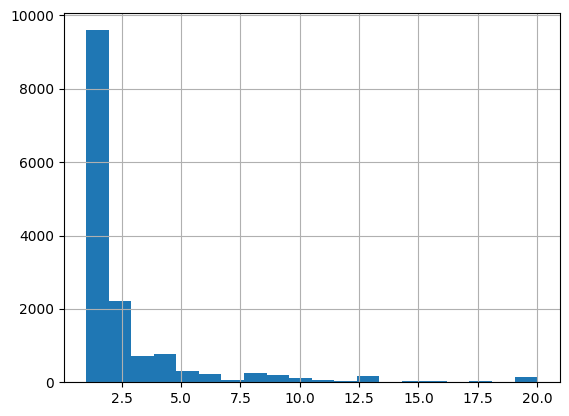

In [30]:
test3_df.filter(pl.col('mol_per_scaf').is_between(0, 20)).group_by('scaffold_idx').first().to_pandas()['mol_per_scaf'].hist(bins=20)

<Axes: >

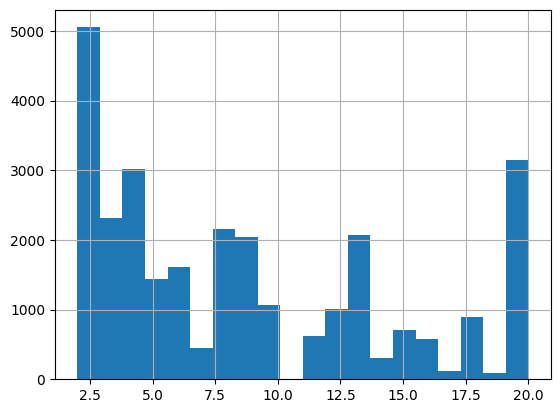

In [117]:
test4_df.filter(pl.col('mol_per_scaf').is_between(1, 20)).group_by('scaffold_idx').first().to_pandas()['mol_per_scaf'].hist(bins=20)

In [119]:
test4_df.filter(pl.col('mol_per_scaf').is_between(1, 20)).group_by('scaffold_idx').first().to_pandas()['mol_per_scaf'].min()

2

In [89]:
test4_df.filter(pl.col('mol_per_scaf').is_between(0, 1)).groupby('scaffold_idx').first().count()

/tmp/ipykernel_2464168/1334723929.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  test4_df.filter(pl.col('mol_per_scaf').is_between(0, 1)).groupby('scaffold_idx').first().count()


scaffold_idx,molecule,bb1,bb2,bb3,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [32]:
test4_df.filter(pl.col('mol_per_scaf').is_between(0, 20)).group_by('scaffold_idx').first().to_pandas()['mol_per_scaf'].value_counts().sort_index()

mol_per_scaf
2     5052
3     2310
4     3020
5     1433
6     1611
7      451
8     2151
9     2036
10    1068
11     614
12    1010
13    2071
14     302
15     708
16     584
17     123
18     890
19      94
20    3143
Name: count, dtype: int64

<Axes: >

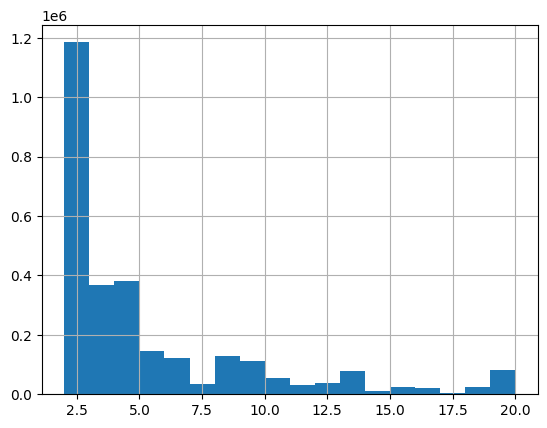

In [120]:
train_df.filter(pl.col('mol_per_scaf').is_between(2, 20)).group_by('scaffold_idx').first().to_pandas()['mol_per_scaf'].hist(bins=18)

In [34]:
train_df.group_by('scaffold_idx').first().describe()

statistic,scaffold_idx,molecule,bb1,bb2,bb3,ori,mol_per_scaf
str,f64,str,f64,f64,f64,f64,f64
"""count""",5.711873e6,"""5711873""",5.711873e6,5.711873e6,5.711873e6,5.711873e6,5.711873e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",2.9859e6,null,1190.967814,1070.118147,1063.178762,0.0,17.265634
"""std""",1.7240e6,null,592.022755,602.359966,598.26569,0.0,516.847742
"""min""",0.0,"""C#CCOc1ccc(CNc…",7.0,16.0,3.0,0.0,1.0
"""25%""",1.492883e6,null,673.0,586.0,578.0,0.0,1.0
"""50%""",2.985789e6,null,1174.0,1094.0,1065.0,0.0,2.0
"""75%""",4.478989e6,null,1758.0,1563.0,1543.0,0.0,4.0
"""max""",5.971684e6,"""O=c1ncnc(Nc2nc…",2084.0,2097.0,2106.0,0.0,500170.0


In [35]:
test2_df.shape

(369039, 7)

In [36]:
(98_415_610  + 369039) / 369039

267.68078441573925

In [37]:
5_971_685 - 245841

5725844

In [38]:
5725844 / 268

21365.089552238805

In [ ]:
369039 / 

In [39]:
test2_df.filter(pl.col('mol_per_scaf').is_between(4000, 6116))['mol_per_scaf'].n_unique()

199

In [40]:
test4_df.filter(pl.col('mol_per_scaf').is_between(4000, 6116))['mol_per_scaf'].unique()

mol_per_scaf
u32
4002
4015
4021
4023
4032
4056
4065
4066
4089


In [41]:
test4_df.filter(pl.col('mol_per_scaf').is_between(6116, 50000000))['mol_per_scaf'].unique()

mol_per_scaf
u32
6116
6124
6134
6144
6150
6159
6161
6206
6208


In [42]:
train_df.filter(pl.col('mol_per_scaf').is_between(4000, 6116))['mol_per_scaf'].unique()

mol_per_scaf
u32
4002
4015
4021
4023
4032
4056
4065
4066
4089


In [43]:
test2_df['mol_per_scaf'].describe()

statistic,value
str,f64
"""count""",369039.0
"""null_count""",0.0
"""mean""",8847.973656
"""std""",44135.506861
"""min""",1.0
"""25%""",47.0
"""50%""",261.0
"""75%""",2305.0
"""max""",500170.0


In [44]:
test2_df.filter(pl.col('mol_per_scaf') > 6116).count()

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
38989,38989,38989,38989,38989,38989,38989


## TODOs
How to choose Test-only BB? by spliting on BB scaffold or not?

In [12]:
df['mol_per_scaf'].max()

500170

In [45]:
all_bbs = bbs_meta['all_bbs']

# stage 1: BB-split
# in this stage, we hold out a set of test-only building blocks
test_only_bbs = set(bbs_meta['test_bbs']).difference(bbs_meta['train_bbs'])
print('Number of test only building blocks:', len(test_only_bbs))
test_only_bb_idxs = [all_bbs.index(bb) for bb in test_only_bbs]
train1_df = df.filter(~ (pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs)))
test1_df = df.filter((pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs)))

display(train1_df.select(pl.col('*').n_unique()))
display(test1_df.select(pl.col('*').n_unique()))

Number of test only building blocks: 965


molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
98784649,271,693,872,5727781,2,2389


molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
508983,70,447,518,245841,1,1014


In [14]:
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

In [15]:
train1_df = train1_df.with_columns(index = pl.Series(list(range(len(train1_df)))))
train1_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844,0
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444,1
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030,2
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814,3
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814,4
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814,5
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814,6
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814,7
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844,8


In [16]:
train1_df.filter(pl.col('mol_per_scaf').is_between(6116, 6150)).select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
2226280,115,451,526,364,2,5,2226280


In [17]:
tmp_train1_df = train1_df.filter(pl.col('mol_per_scaf').is_between(0, 6116))
tmp_train1_df.filter(pl.col('mol_per_scaf') >= 0).select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
79349425,271,693,872,5726656,2,1922,79349425


In [18]:
remain_tmp_train1_df = train1_df.filter(~pl.col('mol_per_scaf').is_between(0, 6116))
remain_tmp_train1_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444,1
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030,2
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814,3
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814,4
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814,5
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814,6
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814,7
"""C#CCOc1ccc(CNc…",1640,1653,728,5084942,0,7616,10
"""C#CCOc1ccc(CNc…",1640,1653,298,2494349,0,133931,11


In [19]:
79349425 / 98784649

0.8032566375773629

Hmm, 6116 is 80% percentile. Let's verify

In [20]:
train1_df.describe(percentiles=[0.8])

statistic,molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""98784649""",9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,1088.99631,1076.385107,1045.043548,3.0288e6,0.003736,15463.047904,4.9392324e7
"""std""",null,590.596121,611.750833,611.632137,1.7254e6,0.061007,58910.282717,2.8517e7
"""min""","""C#CCOc1ccc(CNc…",7.0,0.0,0.0,0.0,0.0,1.0,0.0
"""80%""",null,1723.0,1701.0,1681.0,4.815338e6,0.0,6116.0,7.9027718e7
"""max""","""[N-]=[N+]=NCCC…",2084.0,2109.0,2109.0,5.971684e6,1.0,500170.0,9.8784648e7


In [21]:
79349425 / 172264

460.62685761389497

# Hypothesis 2: BB-split -> Scaffold Split on lower 80% percentile -> Random Split on all

In [47]:
stage2_df = stage2_df.with_columns(index = pl.Series(list(range(len(stage2_df)))))
stage2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844,0
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444,1
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030,2
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814,3
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814,4
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814,5
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814,6
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814,7
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844,8


In [48]:
stage2_df.shape

(98784649, 8)

In [132]:
# lower_stage2_idxs = stage2_df.sort('mol_per_scaf', descending = False)[: int(stage2_df.shape[0] * 0.8), 'index']
# print(len(lower_stage2_idxs))

# lower_stage2_df = stage2_df[lower_stage2_idxs]
# print(lower_stage2_df['mol_per_scaf'].max())


# higher_stage2_df = stage2_df.filter(~pl.col('index').is_in(lower_stage2_idxs))
# higher_stage2_df.shape

79027719

In [49]:
stage2_df['mol_per_scaf'].describe(percentiles=[0.8])

statistic,value
str,f64
"""count""",9.8784649e7
"""null_count""",0.0
"""mean""",15463.047904
"""std""",58910.282717
"""min""",1.0
"""80%""",6116.0
"""max""",500170.0


In [194]:
lower_stage2_df = stage2_df.filter(pl.col('mol_per_scaf').is_between(1, 6116))
higher_stage2_df = stage2_df.filter((pl.col('mol_per_scaf') > 6116) | (pl.col('mol_per_scaf') <=0))

In [195]:
stage2_df.shape

(98784649, 8)

In [196]:
higher_stage2_df.shape

(19435224, 8)

In [197]:
stage2_df.filter(pl.col('mol_per_scaf') == 6116).select(pl.n_unique('*'))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
2177296,107,418,490,356,2,1,2177296


In [198]:
lower_stage2_df.shape

(79349425, 8)

In [199]:
higher_stage2_df.shape

(19435224, 8)

In [205]:
79349425 / 172264

460.62685761389497

In [201]:
79027719 / 172264

458.75934031486554

In [202]:
79027719 / 525

150528.98857142858

In [203]:
1/525

0.0019047619047619048

In [204]:
76916829 / 162_668

472.84548282391125

In [304]:
# splitter = StratifiedGroupKFold(n_splits=573, shuffle=True, random_state=42)
splitter = GroupKFold(n_splits=500)

fold2_meta = {}
for i, (tmp_train2_idxs, tmp_test2_idxs) in enumerate(splitter.split(range(len(lower_stage2_df)), range(len(lower_stage2_df)), lower_stage2_df['scaffold_idx'])):
    print(f"Fold {i}:")
    train2_idxs = lower_stage2_df[tmp_train2_idxs, 'index'].to_list()
    test2_idxs = lower_stage2_df[tmp_test2_idxs, 'index'].to_list()
    print(len(train2_idxs), len(test2_idxs))
    fold2_meta[i] = {}
    fold2_meta[i]['train'] = train2_idxs
    fold2_meta[i]['test'] = test2_idxs
    if i >= 0:
        break

Fold 0:
79190726 158699


In [305]:
len(train2_idxs), len(test2_idxs)

(79190726, 158699)

In [306]:
import gc
gc.collect()

0

In [307]:
stage2_df.shape

(98784649, 8)

In [308]:
gen_train2_df = stage2_df[train2_idxs]
gen_train2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844,0
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844,8
"""C#CCOc1ccc(CNc…",1640,1653,121,2571428,0,864,9
"""C#CCOc1ccc(CNc…",1640,1653,1134,4654763,0,1728,12
"""C#CCOc1ccc(CNc…",1640,1653,1896,5600610,0,864,13
"""C#CCOc1ccc(CNc…",1640,1653,1617,2301320,0,844,17
"""C#CCOc1ccc(CNc…",1640,1653,1150,4484748,0,2595,19
"""C#CCOc1ccc(CNc…",1640,1653,802,1825155,0,844,21
"""C#CCOc1ccc(CNc…",1640,1653,815,2021587,0,3396,23


In [309]:
gen_test2_df = stage2_df[test2_idxs]
gen_test2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CC[C@@H](CC(…",1640,1982,655,5305031,0,6116,1222
"""C#CC[C@@H](CC(…",1640,2090,655,5305031,0,6116,1976
"""C#CC[C@@H](CC(…",1640,740,666,3622246,0,40,4548
"""C#CC[C@@H](CC(…",1640,740,1471,3193630,0,100,4749
"""C#CC[C@@H](CC(…",1640,740,247,3193630,0,100,4750
"""C#CC[C@@H](CC(…",1640,740,219,3193630,0,100,4751
"""C#CC[C@@H](CC(…",1640,740,487,3193630,0,100,4752
"""C#CC[C@@H](CC(…",1640,740,1751,3193630,0,100,4753
"""C#CC[C@@H](CC(…",1640,136,1372,5411475,0,904,7172


In [310]:
gen_test2_df.describe(percentiles=PERCENTILES)

statistic,molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""158699""",158699.0,158699.0,158699.0,158699.0,158699.0,158699.0,158699.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,1100.87482,1095.139163,1076.178817,3.1523e6,0.017511,914.472511,4.9954e7
"""std""",null,587.81115,617.139602,610.401692,1.8187e6,0.131166,1540.533764,2.8985e7
"""min""","""C#CCOc1ccc(CNc…",7.0,0.0,0.0,15.0,0.0,1.0,1222.0
"""1%""",null,21.0,26.0,23.0,69717.0,0.0,1.0,942885.0
"""2.5%""",null,104.0,49.0,53.0,134115.0,0.0,1.0,2.306146e6
"""5%""",null,170.0,103.0,127.0,272306.0,0.0,2.0,4.692601e6
"""10%""",null,346.0,207.0,227.0,506992.0,0.0,5.0,9.653092e6


In [311]:
gen_test2_df.filter(pl.col('mol_per_scaf').is_between(2000, 5000000)).group_by('scaffold_idx').first().group_by('mol_per_scaf').count().sort('mol_per_scaf')

/tmp/ipykernel_2464168/4259884994.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  gen_test2_df.filter(pl.col('mol_per_scaf').is_between(2000, 5000000)).group_by('scaffold_idx').first().group_by('mol_per_scaf').count().sort('mol_per_scaf')


mol_per_scaf,count
u32,u32
2276,1
2305,1
2723,1
3597,1
3667,1
4646,1
6116,1


In [312]:
test3_df.filter(pl.col('mol_per_scaf').is_between(500, 5000000)).group_by('scaffold_idx').first().group_by('mol_per_scaf').count().sort('mol_per_scaf')

/tmp/ipykernel_2464168/2285076470.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  test3_df.filter(pl.col('mol_per_scaf').is_between(500, 5000000)).group_by('scaffold_idx').first().group_by('mol_per_scaf').count().sort('mol_per_scaf')


mol_per_scaf,count
u32,u32
504,1
517,1
522,1
524,1
528,1
530,1
582,1
619,1
659,1


In [313]:
import gc
gc.collect()

0

In [314]:
gen_test2_df.select(pl.n_unique('*'))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
158699,271,693,869,11453,2,193,158699


In [315]:
higher_stage2_df.shape

(19435224, 8)

In [316]:
stage3_df = pl.concat([higher_stage2_df, gen_train2_df])
stage3_df.shape

(98625950, 8)

In [317]:
98625950 + test1_df.shape[0] + gen_test2_df.shape[0] - 878_022

98415610

In [318]:
(98625950 + test1_df.shape[0] + gen_test2_df.shape[0] - 878_022) / (test1_df.shape[0] + gen_test2_df.shape[0] - 878_022)

-467.8882285822953

In [319]:
test1_df.shape[0] + gen_test2_df.shape[0] - 878_022

-210340

In [320]:
test2_df.shape[0] - gen_test2_df.shape[0]

210340

In [321]:
98410745 / 215205

457.2883761994377

In [322]:
# splitter = StratifiedGroupKFold(n_splits=573, shuffle=True, random_state=42)
splitter = KFold(n_splits=468, shuffle=True, random_state=42)

fold3_meta = {}
for i, (tmp_train3_idxs, tmp_test3_idxs) in enumerate(splitter.split(range(len(stage3_df)))):
    print(f"Fold {i}:")
    # train2_idxs = tmp_train1_df[tmp_train2_idxs, 'index'].to_list()
    # test2_idxs = tmp_train1_df[tmp_test2_idxs, 'index'].to_list()
    train3_idxs = tmp_train3_idxs
    test3_idxs = tmp_test3_idxs
    print(len(train3_idxs), len(test3_idxs))
    fold3_meta[i] = {}
    fold3_meta[i]['train'] = train3_idxs
    fold3_meta[i]['test'] = test3_idxs
    if i >= 0:
        break
fold3_meta

Fold 0:
98415210 210740


{0: {'train': array([       0,        1,        2, ..., 98625947, 98625948, 98625949]),
  'test': array([      40,      698,     1724, ..., 98624522, 98624688, 98624981])}}

In [323]:
gen_test3_df = stage3_df[test3_idxs]
gen_train3_df = stage3_df[train3_idxs]
gen_test3_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1ccc(CNc…",1640,1653,843,806999,0,14112,85
"""C#CC[C@@H](CC(…",1640,1982,785,4789196,0,12232,1612
"""C#CC[C@@H](CC(…",1640,1784,1702,1413163,0,8640,3774
"""C#CC[C@@H](CC(…",1640,253,1824,585701,0,41322,5631
"""C#CC[C@@H](CC(…",1640,15,1941,2963783,0,195471,6359
"""C#CC[C@@H](CC(…",1640,136,1732,2080038,0,40035,6812
"""C#CC[C@@H](CC(…",1640,136,1161,4867705,0,246438,6972
"""C#CC[C@@H](CC(…",1640,17,386,2963783,0,195471,8241
"""C#CC[C@@H](CC(…",1640,17,192,162518,0,237652,8268


In [324]:
gen_test3_df.select(pl.n_unique('*'))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
210740,271,693,871,117641,2,2331,210740


In [325]:
test2_df.shape

(369039, 7)

In [326]:
gen_test2_df.filter(pl.col('mol_per_scaf') == 1)

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C=C1CCC(CNc2nc…",873,740,116,1771451,0,1,4724314
"""Cn1ccc2cc(Nc3n…",873,734,1795,3067872,0,1,4730853
"""CC(C)(C)OC(=O)…",873,909,1644,2040881,0,1,4733904
"""CC(C)Cn1cnc2c(…",873,855,1768,3094529,0,1,4735944
"""CC(C)c1nnc([C@…",873,1563,105,4883419,0,1,4737210
"""CC(CNc1nc(Nc2n…",873,79,1932,335382,0,1,4738109
"""CCC1=NN(Cc2ccc…",873,518,925,4810975,0,1,4739133
"""CC(CNc1nc(NCCc…",873,1770,1726,1030674,0,1,4741135
"""CC(O)(CNc1nc(N…",873,1222,659,4408914,0,1,4742450


In [327]:
gen_test2_df.select(pl.n_unique('scaffold_idx'))

scaffold_idx
u32
11453


In [328]:
gen_test3_df.filter(pl.col('mol_per_scaf') <= 1)['scaffold_idx'].n_unique()

5167

In [329]:
gen_test_df = pl.concat([gen_test2_df, gen_test3_df])
gen_test_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CC[C@@H](CC(…",1640,1982,655,5305031,0,6116,1222
"""C#CC[C@@H](CC(…",1640,2090,655,5305031,0,6116,1976
"""C#CC[C@@H](CC(…",1640,740,666,3622246,0,40,4548
"""C#CC[C@@H](CC(…",1640,740,1471,3193630,0,100,4749
"""C#CC[C@@H](CC(…",1640,740,247,3193630,0,100,4750
"""C#CC[C@@H](CC(…",1640,740,219,3193630,0,100,4751
"""C#CC[C@@H](CC(…",1640,740,487,3193630,0,100,4752
"""C#CC[C@@H](CC(…",1640,740,1751,3193630,0,100,4753
"""C#CC[C@@H](CC(…",1640,136,1372,5411475,0,904,7172


In [330]:
gen_train3_df = stage3_df[train3_idxs]

In [331]:
gen_train3_df.shape

(98415210, 8)

In [332]:
gen_train_df = gen_train3_df

In [333]:
gen_test_df.select(pl.n_unique('*'))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
369439,271,693,872,129094,2,2333,369439


In [334]:
gen_test_only_scaffold_idxs = list(set(gen_test_df['scaffold_idx']).difference(set(gen_train_df['scaffold_idx'])))
print('Number of pseudo test-only scaffold_idxs:', len(gen_test_only_scaffold_idxs))

Number of pseudo test-only scaffold_idxs: 16623


In [335]:
gen_test_df.filter(pl.col('scaffold_idx').is_in(gen_test_only_scaffold_idxs)).select(pl.n_unique('*'))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
163872,271,693,870,16623,2,193,163872


For pseudo part: The number of scaffold which mol_per_scaffold == 1 is too large.
When a Random Split is performed without range filtering, the obtainted test split will contain almost "small" test-only scaffold cluster (cluster with less than 2 mol_per_scaf).

In [ ]:
increase number of distince molecules, but reduce the number of distince scaffolds
-> Stage 2: 480 folds, Stage 3: 483 folds -> 170.2k and 16.8k

# less molecules (163.9k vs 172.2k), but more scaffolds (16.6k vs 15.9k) -> 

In [190]:
test3_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""COC(=O)c1sc(C)…",51,1011,1718,295936,1,4818
"""COC(=O)c1sc(C)…",575,324,1718,295936,1,4818
"""N#Cc1ccnc(Nc2n…",1945,361,1604,5741906,1,4276
"""Cc1cccc(CCCNc2…",1765,2041,223,267904,1,3
"""COC(=O)c1cc(Nc…",1752,143,324,295936,1,4818
"""O=C1CCC(Nc2nc(…",1235,731,2054,707380,1,2
"""O=C(C[C@H](Cc1…",513,1401,1638,5711773,1,3
"""COC(=O)c1sc(C)…",1003,1948,1718,5643208,1,582
"""O=C(N[Dy])c1cn…",171,381,1065,2249472,1,271


In [31]:
test2_mol_per_scaffold = test2_df.group_by('scaffold_idx').agg(
    pl.col('molecule').count()
).sort('molecule')
test2_mol_per_scaffold.describe(percentiles = PERCENTILES)

statistic,scaffold_idx,molecule
str,f64,f64
"""count""",11453.0,11453.0
"""null_count""",0.0,0.0
"""mean""",3.0074e6,13.856544
"""std""",1.7323e6,111.703431
"""min""",785.0,1.0
"""1%""",49939.0,1.0
"""2.5%""",142744.0,1.0
"""5%""",298141.0,1.0
"""10%""",596273.0,1.0


In [32]:
11453.0 * 500

5726500.0

In [33]:
test2_mol_per_scaffold.filter(pl.col('molecule') == 1).count()

scaffold_idx,molecule
u32,u32
4865,4865


In [34]:
4865 / 11453.0

0.4247795337466166

In [35]:
test1_df.shape, test2_df.shape, sub_train2_df.shape

((508983, 7), (158699, 8), (79190726, 8))

In [36]:
# train2_df = pl.concat([remain_tmp_train1_df, sub_train2_df]).sort('index')
# train2_df

In [55]:
508983 + 158699 - 878_022

-210340

In [60]:
98_625_950  + 508983 + 158699 - 878_022

98415610

In [64]:
210340 / 98_625_950

0.0021327044251538262

In [37]:
1 / (210340 / 79_190_726)

376.48914139013027

In [38]:
sub_train2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844,0
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844,8
"""C#CCOc1ccc(CNc…",1640,1653,121,2571428,0,864,9
"""C#CCOc1ccc(CNc…",1640,1653,1134,4654763,0,1728,12
"""C#CCOc1ccc(CNc…",1640,1653,1896,5600610,0,864,13
"""C#CCOc1ccc(CNc…",1640,1653,1617,2301320,0,844,17
"""C#CCOc1ccc(CNc…",1640,1653,1150,4484748,0,2595,19
"""C#CCOc1ccc(CNc…",1640,1653,802,1825155,0,844,21
"""C#CCOc1ccc(CNc…",1640,1653,815,2021587,0,3396,23


In [39]:
sub_train2_df.filter(pl.col('mol_per_scaf').is_between(0, 1043)).select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
60700019,271,693,872,5707611,2,887,60700019


In [40]:
60700019 / 98784649

0.6144681346187706

In [41]:
60700019 / 79_190_726

0.766504135850453

In [42]:
train1_df.describe(percentiles=[0.6])

statistic,molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""98784649""",9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7,9.8784649e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,1088.99631,1076.385107,1045.043548,3.0288e6,0.003736,15463.047904,4.9392324e7
"""std""",null,590.596121,611.750833,611.632137,1.7254e6,0.061007,58910.282717,2.8517e7
"""min""","""C#CCOc1ccc(CNc…",7.0,0.0,0.0,0.0,0.0,1.0,0.0
"""60%""",null,1253.0,1324.0,1266.0,3.634655e6,0.0,957.0,5.9270789e7
"""max""","""[N-]=[N+]=NCCC…",2084.0,2109.0,2109.0,5.971684e6,1.0,500170.0,9.8784648e7


In [46]:
sub_train2_df.describe(percentiles=[0.75])

statistic,molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""79190726""",7.9190726e7,7.9190726e7,7.9190726e7,7.9190726e7,7.9190726e7,7.9190726e7,7.9190726e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,1093.570747,1076.411531,1046.044747,2.9842e6,0.004161,910.01741,5.0046e7
"""std""",null,592.099056,605.966167,608.234867,1.7321e6,0.064371,1520.709653,2.8919e7
"""min""","""C#CCOc1ccc(CNc…",7.0,0.0,0.0,0.0,0.0,1.0,0.0
"""75%""",null,1622.0,1572.0,1541.0,4.490915e6,0.0,957.0,7.6157377e7
"""max""","""[N-]=[N+]=NCCC…",2084.0,2109.0,2109.0,5.971684e6,1.0,6116.0,9.8784648e7


In [48]:
len(df)

99293632

In [49]:
df['mol_per_scaf'].describe(percentiles = [0.8])

statistic,value
str,f64
"""count""",9.9293632e7
"""null_count""",0.0
"""mean""",15385.840077
"""std""",58772.558018
"""min""",1.0
"""80%""",6116.0
"""max""",500170.0


In [54]:
train1_df['mol_per_scaf'].describe(percentiles = [0.8])

statistic,value
str,f64
"""count""",9.8784649e7
"""null_count""",0.0
"""mean""",15463.047904
"""std""",58910.282717
"""min""",1.0
"""80%""",6116.0
"""max""",500170.0


80% number of samples has mol_per_scaf <= 6116.
-> Split by Scaffold: keep top 20% for training. The remaining 80% -> random split

In [55]:
train1_df.filter(pl.col('mol_per_scaf') <= 6116).shape

(79349425, 8)

In [56]:
878_022 - 508983

369039

In [58]:
1 / (369039 / 79349425)

215.01636683385766

# Follow hypothesis 2: Split by Scaffold: keep top 20% for training. The remaining 80% -> random split

# Follow hypothesis 3: After BB-split in stage 1, do a Random Split on the remaining

In [55]:
train_df.shape

(98415610, 7)

In [56]:
test2_df.shape

(369039, 7)

In [46]:
stage2_df = pl.concat([train_df, test2_df])
stage2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,4283326,0,844
"""C#CCOc1ccc(CNc…",1640,1653,205,4486646,0,9444
"""C#CCOc1ccc(CNc…",1640,1653,1653,1015728,0,9030
"""C#CCOc1ccc(CNc…",1640,1653,146,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,196,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,253,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,1219,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,604,543172,0,844


In [60]:
test2_df.shape

(369039, 7)

In [61]:
98_784_649 / 369039

267.68078441573925

In [100]:
# splitter = StratifiedGroupKFold(n_splits=573, shuffle=True, random_state=42)
splitter = KFold(n_splits=267, shuffle=True, random_state=42)

fold2_meta = {}
for i, (tmp_train2_idxs, tmp_test2_idxs) in enumerate(splitter.split(range(len(stage2_df)))):
    print(f"Fold {i}:")
    # train2_idxs = tmp_train1_df[tmp_train2_idxs, 'index'].to_list()
    # test2_idxs = tmp_train1_df[tmp_test2_idxs, 'index'].to_list()
    train2_idxs = tmp_train2_idxs
    test2_idxs = tmp_test2_idxs
    print(len(train2_idxs), len(test2_idxs))
    fold2_meta[i] = {}
    fold2_meta[i]['train'] = train2_idxs
    fold2_meta[i]['test'] = test2_idxs
    if i >= 1:
        break
fold2_meta

Fold 0:
98414669 369980
Fold 1:
98414669 369980


{0: {'train': array([       0,        1,        2, ..., 98784646, 98784647, 98784648]),
  'test': array([      40,      604,      698, ..., 98784426, 98784437, 98784585])},
 1: {'train': array([       0,        1,        2, ..., 98784646, 98784647, 98784648]),
  'test': array([       4,       32,      122, ..., 98783717, 98783753, 98784174])}}

In [101]:
gen_test2_df = stage2_df[test2_idxs]
gen_test2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""C#CCOc1ccc(CNc…",1640,1653,439,5301385,0,26814
"""C#CCOc1ccc(CNc…",1640,1653,1259,1142928,0,1688
"""C#CCOc1ccc(CNc…",1640,1653,1863,2494349,0,133931
"""C#CCOc1cccc(CN…",1640,1596,726,3435799,0,1708
"""C#CCOc1cccc(CN…",1640,1596,783,5928562,0,5660
"""C#CCOc1cccc(CN…",1640,1596,1552,2494349,0,133931
"""C#CCOc1cccc(CN…",1640,1596,1928,1542308,0,1688
"""C#CC[C@@H](CC(…",1640,1982,282,5533127,0,6116
"""C#CC[C@@H](CC(…",1640,1982,1065,2513749,0,6116


In [102]:
245841 + 123824 - 368_671

994

In [103]:
gen_test2_df.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
369980,271,693,872,184991,2,2376


In [104]:
gen_test2_df['mol_per_scaf'].max()

500170

In [105]:
98414669 + 369980 == stage2_df.shape[0]

True

In [106]:
gen_train2_df = stage2_df[train2_idxs]
gen_train2_df.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
u32,u32,u32,u32,u32,u32,u32
98414669,271,693,872,5718698,2,2389


In [107]:
gen_test_only_scaffolds = list(set(gen_test2_df['scaffold_idx']).difference(set(gen_train2_df['scaffold_idx'])))
len(gen_test_only_scaffolds)

9083

In [108]:
gen_test2_df['mol_per_scaf'].max()

500170

In [109]:
gen_test2_df.filter(pl.col('scaffold_idx').is_in(gen_test_only_scaffolds))['mol_per_scaf'].max()

2

In [110]:
gen_train2_df.filter(pl.col('mol_per_scaf').is_between(2, 10))

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf
str,u16,u16,u16,i64,i32,u32
"""C=C1CCC(CNc2nc…",873,740,728,4121402,0,9
"""C=C1CCC(CNc2nc…",873,740,1134,2966733,0,2
"""C=C1CCC(CNc2nc…",873,740,1694,5303914,0,9
"""C=C1CCC(CNc2nc…",873,740,1150,1105998,0,3
"""C=C1CCC(CNc2nc…",873,740,815,2700573,0,4
"""C=C1CCC(CNc2nc…",873,740,365,3353364,0,5
"""C=C1CCC(CNc2nc…",873,740,1935,3353364,0,5
"""C=C1CCC(CNc2nc…",873,740,1259,4591752,0,2
"""C=C1CCC(CNc2nc…",873,740,902,1105998,0,3


In [61]:
test2_df = train1_df[test2_idxs]
test2_df

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
str,u16,u16,u16,i64,i32,u32,i64
"""C#CCOc1cccc(CN…",1640,1596,655,3852867,0,864,532
"""C#CCOc1cccc(CN…",1640,1596,534,5500217,0,844,999
"""C#CC[C@@H](CC(…",1640,1982,1799,5211571,0,6116,1546
"""C#CC[C@@H](CC(…",1640,1982,1908,4490452,0,6116,1626
"""C#CC[C@@H](CC(…",1640,1982,1688,4178287,0,6116,1747
"""C#CC[C@@H](CC(…",1640,1982,1299,2933007,0,6116,1784
"""C#CC[C@@H](CC(…",1640,2090,1961,3437684,0,6116,1979
"""C#CC[C@@H](CC(…",1640,2090,1081,5365050,0,6116,2459
"""C#CC[C@@H](CC(…",1640,643,288,3593302,0,960,3190


In [63]:
train1_df.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
98784649,271,693,872,5727781,2,2389,98784649


In [62]:
test2_df.select(pl.col('*').n_unique())

molecule,bb1,bb2,bb3,scaffold_idx,ori,mol_per_scaf,index
u32,u32,u32,u32,u32,u32,u32,u32
369068,271,693,872,218019,2,1918,369068


In [52]:
df['mol_per_scaf'].describe(percentiles = [0.61])

statistic,value
str,f64
"""count""",9.9293632e7
"""null_count""",0.0
"""mean""",15385.840077
"""std""",58772.558018
"""min""",1.0
"""61%""",960.0
"""max""",500170.0


In [45]:
0.75 * 0.8

0.6000000000000001

In [ ]:
# splitter = StratifiedGroupKFold(n_splits=573, shuffle=True, random_state=42)
splitter = KFold(n_splits=468, shuffle=True, random_state=42)

fold2_meta = {}
for i, (tmp_train2_idxs, tmp_test2_idxs) in enumerate(splitter.split(range(len(tmp_train1_df)), range(len(tmp_train1_df)), tmp_train1_df['scaffold_idx'])):
    print(f"Fold {i}:")
    train2_idxs = tmp_train1_df[tmp_train2_idxs, 'index'].to_list()
    test2_idxs = tmp_train1_df[tmp_test2_idxs, 'index'].to_list()
    print(len(train2_idxs), len(test2_idxs))
    fold2_meta[i] = {}
    fold2_meta[i]['train'] = train2_idxs
    fold2_meta[i]['test'] = test2_idxs
    if i >= 9:
        break

fold2_meta

In [ ]:
def train_test_split(df):
    all_bbs = bbs_meta['all_bbs']
    
    # stage 1: BB-split
    # in this stage, we hold out a set of test-only building blocks
    test_only_bbs = set(bbs_meta['test_bbs']).difference(bbs_meta['train_bbs'])
    print('Number of test only building blocks:', len(test_only_bbs))
    test_only_bb_idxs = [all_bbs.index(bb) for bb in test_only_bbs]
    train1_df = df.filter(~ (pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs)))
    test1_df = df.filter((pl.col('bb1').is_in(test_only_bb_idxs) | pl.col('bb2').is_in(test_only_bb_idxs) | pl.col('bb3').is_in(test_only_bb_idxs)))

    display(train1_df.select(pl.col('*').n_unique()))
    display(test1_df.select(pl.col('*').n_unique()))

    # stage 2: Scaffold-split
    # author may do a Stratified Group split by 'binds' labels as well
    # only do split with molecule_per_scaffold between a range [1, 6116] (<=80% of molecules, sorted by molecule_per_scaffold)
    # to prevent test include a large number of molecules with same scaffold
    
    train1_df = train1_df.with_columns(id = list(range(len(train1_df))))
    
    
    
    
    return train1_df, test1_df


train1_df, test1_df = train_test_split(df)